In [1]:
import random
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from utils import *

DATA_DIR = Path('data')
SOURCE_DIR = DATA_DIR / 'source'
TARGET_DIR = DATA_DIR / 'target'
NUM_EPOCHS = 100
N_FOLD = 5
CROP_RATIO = 12
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64 if DEVICE == 'cuda' else 2

In [2]:
def read_data(root_path):
    img_paths = root_path.glob('*.png')
    imgs = []
    for img_path in img_paths:
        img = cv2.imread(str(img_path))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

In [3]:
sources = read_data(SOURCE_DIR)
targets = read_data(TARGET_DIR)

KeyboardInterrupt: 

In [ ]:
shape = sources[0].shape

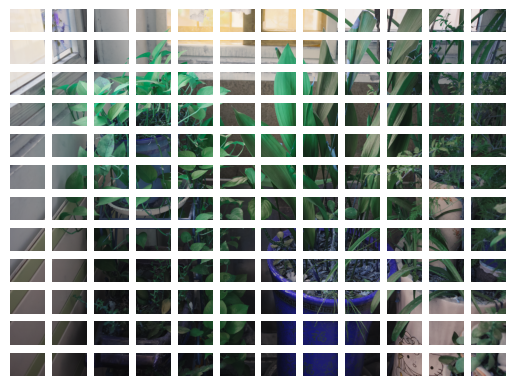

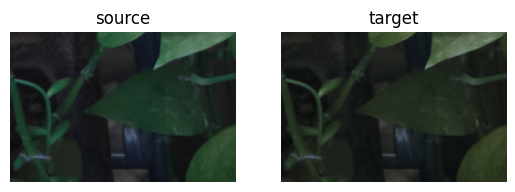

In [ ]:
def crop_imgs(imgs, show=False):
    croped_imgs = []
    for img in imgs:
        h, w, _ = img.shape
        dx = int(w / CROP_RATIO)
        dy = int(h / CROP_RATIO)
        for i in range(CROP_RATIO):
            for j in range(CROP_RATIO):
                start_x = j * dx
                start_y = i * dy
                end_x = min(start_x + dx, w)
                end_y = min(start_y + dy, h)
                croped_imgs.append(img[start_y:end_y, start_x:end_x, :])
    if show:
        for i, img in enumerate(croped_imgs[:CROP_RATIO*CROP_RATIO]):
            plt.subplot(CROP_RATIO, CROP_RATIO, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()
    return croped_imgs

sources_croped = crop_imgs(sources, show=True)
targets_croped = crop_imgs(targets)

# test croped images
ax = plt.subplot(1, 2, 1)
ax.imshow(sources_croped[100])
ax.set_title('source')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.set_title('target')
ax.imshow(targets_croped[100])
ax.axis('off')
plt.show()

In [ ]:
import random


def generate_img(sources_croped, targets_croped, num=1000, output='data_gen', show=False):
    assert (len(sources_croped) == len(targets_croped))
    output = Path(output)
    output_source = output / 'source'
    output_target = output / 'target'
    output.mkdir(exist_ok=True)
    output_source.mkdir(exist_ok=True)
    output_target.mkdir(exist_ok=True)
    len_max = len(sources_croped)
    for i in tqdm(range(num)):
        source_path = output_source / f'{i}.png'
        target_path = output_target / f'{i}.png'
        
        source = None
        target = None
        for j in [random.randint(0, len_max-1) for _ in range(CROP_RATIO)]:
            source_tmp = None
            target_tmp = None
            for k in [random.randint(0, len_max-1) for _ in range(CROP_RATIO)]:
                if source_tmp is None:
                    source_tmp = sources_croped[k]
                    target_tmp = targets_croped[k]
                else:
                    source_tmp = np.concatenate((source_tmp, sources_croped[k]), axis=0)
                    target_tmp = np.concatenate((target_tmp, targets_croped[k]), axis=0)
            if source is None:
                source = source_tmp
                target = target_tmp
            else:
                source = np.concatenate((source, source_tmp), axis=1)
                target = np.concatenate((target, target_tmp), axis=1)
        if show:
            ax = plt.subplot(1, 2, 1)
            ax.imshow(source)
            ax.set_title('source')
            ax.axis('off')
            ax = plt.subplot(1, 2, 2)
            ax.set_title('target')
            ax.imshow(target)
            ax.axis('off')
            plt.show()
            break
        cv2.imwrite(str(source_path), source)
        cv2.imwrite(str(target_path), target)
generate_img(sources_croped, targets_croped)
                
                

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

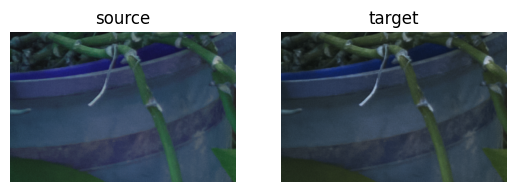

In [ ]:
class fujiDataset(Dataset):
    def __init__(self, sources_imgs, targets_imgs):
        self.sources_imgs = sources_imgs
        self.targets_imgs = targets_imgs

    def __len__(self):
        return len(self.sources_imgs)
    
    def __getitem__(self, idx):
        return self.sources_imgs[idx], self.targets_imgs[idx]

def get_kfold_ds(fold, source_imgs, target_imgs):
    assert(len(source_imgs) == len(target_imgs))
    train_source_imgs = []
    valid_source_imgs = []
    train_target_imgs = []
    valid_target_imgs = []
    for i in range(N_FOLD):
        slc = slice(i, None, N_FOLD)
        if (i + 1) == fold:
            valid_source_imgs.extend(source_imgs[slc])
            valid_target_imgs.extend(target_imgs[slc])
        else:
            train_source_imgs.extend(source_imgs[slc])
            train_target_imgs.extend(target_imgs[slc])
    train_ds = fujiDataset(train_source_imgs, train_target_imgs)
    valid_ds = fujiDataset(valid_source_imgs, valid_target_imgs)
    return train_ds, valid_ds

train_ds, valid_ds = get_kfold_ds(1, sources_croped, targets_croped)

# test croped images
ax = plt.subplot(1, 2, 1)
ax.imshow(train_ds[10][0])
ax.set_title('source')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.set_title('target')
ax.imshow(train_ds[10][1])
ax.axis('off')
plt.show()

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE)

In [ ]:
import time

from ssim import ssim

#test
test1 = torch.Tensor([np.transpose(sources[0], (2, 0, 1))])
test2 = torch.Tensor([np.transpose(targets[0], (2, 0, 1))])

C:\Users\24871\AppData\Local\Temp\ipykernel_34940\2117159329.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  test1 = torch.Tensor([np.transpose(sources[0], (2, 0, 1))])


In [ ]:
class fujiModel(nn.Module):
    def __init__(self):
        super().__init__()
        